<a href="https://colab.research.google.com/github/kotekjedi/GANs-ITMO-2022-Masters/blob/main/Assignment%201/1_gan_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Models
***

**ITMO University, Autumn 2022, MSc course**


## Assignment 1

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Alexander Panfilov*

***


The assignment is split into two parts: at first, you will implement classical GAN for the MNIST dataset, and after, you will enhance your results with DCGAN and the CIFAR10 dataset. 

Good luck!

## 1. GAN
*Source: <a href="https://arxiv.org/pdf/1406.2661.pdf" target="_blank">Goodfellow, Ian J., et al. "Generative Adversarial Networks." arXiv preprint arXiv:1406.2661 (2014)</a>.*

In 2014, Ian Goodfellow and his colleagues at the University of Montreal published a stunning paper introducing the world to GANs, or generative adversarial networks. The models play two distinct (literally, adversarial) roles. Given some real data set $\mathcal{X}$, $G$ is the generator, trying to create fake data that looks just like the genuine data, while $D$ is the discriminator, getting data from either the real set or $G$ and labeling the difference.

Goodfellow’s metaphor (and a fine one it is) was that $G$ was like a team of forgers trying to match real paintings with their output, while $D$ was the team of detectives trying to tell the difference. (Except in this case, the forgers $G$ never get to see the original data — only the judgments of $D$. They’re like blind forgers.)

<img src="https://production-media.paperswithcode.com/methods/gan.jpeg" style="display=block; margin:auto"/>
<p style="text-align: center">
    <b>Picture taken from the <a href="https://paperswithcode.com/method/gan" target="_blank">paperswithcode</a> website. There you can find a whole bunch of papers on GANs with implementation.</b>
</p>

In this part, we are going to implement classical GAN. You can find a rough plan on how to do it below; however, it is not mandatory to stick with it precisely but one might expect some questions related to the listed steps. Feel free to adapt provided code!

- Define the parameters
- Load the data (with transforms and normalization)
- Denormalize for visual inspection of samples
- Define the Discriminator network, the Generator network
- Study the activation function: Leaky ReLU
- Explain the output activation function: Tanh, Sigmoid
- Look at some sample outputs
- Define losses, optimizers and helper functions for training
     - For Discriminator
     - For Generator
- Train the model
- Save intermediate generated images to file
- Look at some outputs
- Save the models

### Imports

In [14]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import save_image

%matplotlib inline
plt.style.use("ggplot")

### Define parameters & data loading 

In [15]:
hidden_size = 256
batch_size = 100
LR = 0.0002
num_epochs = 300
sample_dir = "./images"
latent_size = 64  # input random input vector latent
image_size = 784  # 28*28 flatten
device = "cuda" if torch.cuda.is_available() else "cpu"

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
## Define the dataset
mnist_dataset = MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]),
)

Label:  5


(array([55.,  4.,  3.,  0.,  3.,  2.,  1.,  0.,  1.,  3.,  1.,  3.,  2.,
         1., 21.]),
 array([-1.        , -0.86771244, -0.73542482, -0.60313725, -0.47084966,
        -0.3385621 , -0.20627451, -0.07398693,  0.05830066,  0.19058824,
         0.32287583,  0.45516339,  0.58745098,  0.71973854,  0.85202616,
         0.98431373]),
 <BarContainer object of 15 artists>)

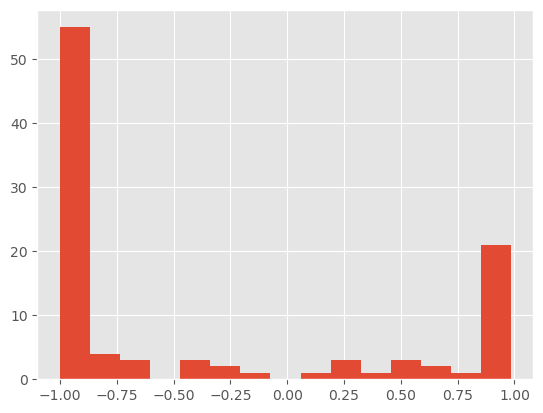

In [16]:
img, label = mnist_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [17]:
# denormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
    return (x + 1) / 2

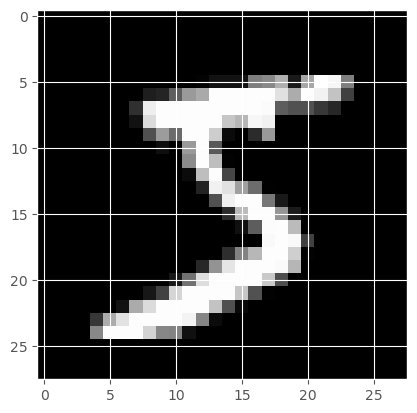

In [18]:
# show image sample with matplotlib
plt.imshow(denorm(img[0]), cmap='gray')

In [19]:
# define the dataloader
from torch.utils.data import DataLoader
data_loader = DataLoader(dataset = mnist_dataset, shuffle = True, batch_size = batch_size)

### GAN implementation

GAN consists of two deep networks, a generator ($G$) and a discriminator ($D$). The generator creates images before learning it. Since the discriminator is a binary classification model, we can use the binary cross-entropy loss function to quantify how well it can distinguish between real and generated images.

In [20]:
class Generator(nn.Module):
    def __init__(self, latent_size, image_size, hidden_size):
        super(Generator, self).__init__()
        self.linear_1 = nn.Linear(latent_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, image_size)

        self.model = nn.Sequential(self.linear_1, nn.ReLU(), self.linear_2, nn.ReLU(), self.linear_3, nn.Tanh())

    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> tanh
        return self.model(x)

# The ReLU activation is used in the generator except the output layer which uses the Tanh function. […] Within the discriminator we found the leaky rectified activation to work well …

class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size):
        super(Discriminator, self).__init__()
        self.linear_1 = nn.Linear(image_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, 1)

        self.model = nn.Sequential(self.linear_1, nn.LeakyReLU(), self.linear_2, nn.LeakyReLU(), self.linear_3, nn.Sigmoid())

    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> sigmoid
        return self.model(x)

### Create the Generator and Discriminator

In [21]:
# create new Generator model
G = Generator(latent_size, image_size, hidden_size)
G = G.to(device)

# create new Discriminator model
D = Discriminator(image_size, hidden_size)
D = D.to(device)

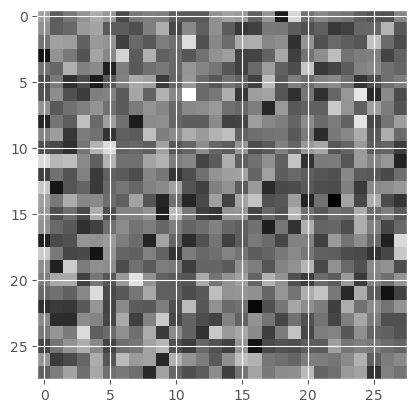

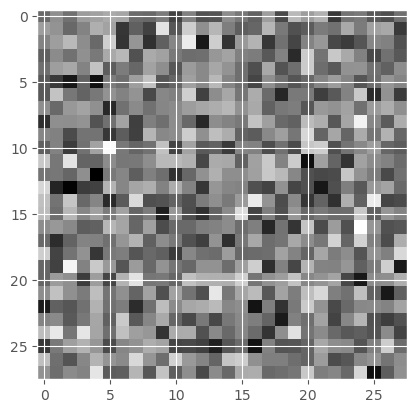

In [22]:
# show the output of model
y = G(torch.randn(2, latent_size).to(device))

plt.imshow(y.detach().cpu()[0].reshape(28, 28), cmap='gray')
plt.show()
plt.imshow(y.detach().cpu()[1].reshape(28, 28), cmap='gray')

In [23]:
# define the criterion is nn.BCELoss()
loss_fn = nn.BCELoss()
## Define the optimizer for generator and discriminator
g_optimizer = torch.optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))
# source: Tips for Training Stable Generative Adversarial Networks

Discriminator Training

In [24]:
def reset_grad():
    ## reset gradient for optimizer of generator and discriminator
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()

def train_discriminator(D_model, G_model, images, device=device, batch_size=batch_size, latent_size=latent_size, additional_sizes = None):
  
    extra = []
    if additional_sizes is not None:
        extra = additional_sizes

    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1, *extra).to(device)
    fake_labels = torch.zeros(batch_size, 1, *extra).to(device)
        
    
    outputs = D_model(images)
    # Loss for real images
    
    real_score = outputs


    # Loss for fake images
    z = torch.randn(batch_size, latent_size, *extra).to(device)
    fake_images = G_model(z)
    outputs = D_model(fake_images)

    fake_score = outputs

    # Sum losses

    d_loss = loss_fn(real_score, real_labels) + loss_fn(fake_score, fake_labels)

    # Reset gradients
    reset_grad()
    # Compute gradients
    
    # computes gradient of loss w.r.t all the parameters in loss that have requires_grad = True and stores them in parameter.grad attribute for every parameter.
    d_loss.backward()

    # Adjust the parameters using backprop
    
    d_optimizer.step()

    return d_loss, real_score, fake_score

Generator Training

In [25]:
def train_generator(D_model, G_model, device=device, batch_size=batch_size, latent_size=latent_size, additional_sizes = None):
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    extra = []
    if additional_sizes is not None:
        extra = additional_sizes
    z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size, *extra))).to(device)
    fake_images = G_model(z)
    labels = torch.ones(batch_size, 1, *extra).to(device)
    # calculate the generator loss

    g_loss = loss_fn(D_model(fake_images), labels)

    # Reset gradients

    reset_grad()

    # Backprop and optimize

    g_loss.backward()
    g_optimizer.step()

    return g_loss, fake_images

### Start the training process

In [26]:
# function to save the sample output of generator
def save_fake_images_mnist(G_model, index, sample_dir=sample_dir, device=device, batch_size=batch_size, latent_size=latent_size):
    # sample_vectors = torch.randn(batch_size, latent_size).to(device)
    sample_vectors = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(
        device
    )
    fake_images = G_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [27]:
%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(D, G, images)
        # Train the generator
        g_loss, fake_images = train_generator(D, G)
        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_mnist(G, epoch + 1)

Epoch [0/300], Step [200/600], d_loss: 0.9407, g_loss: 1.1636, D(x): 0.68, D(G(z)): 0.42
Epoch [0/300], Step [400/600], d_loss: 0.8117, g_loss: 1.6571, D(x): 0.80, D(G(z)): 0.41
Epoch [0/300], Step [600/600], d_loss: 0.6000, g_loss: 2.0222, D(x): 0.74, D(G(z)): 0.19
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.3143, g_loss: 2.9898, D(x): 0.88, D(G(z)): 0.10
Epoch [1/300], Step [400/600], d_loss: 0.4442, g_loss: 2.1087, D(x): 0.82, D(G(z)): 0.17
Epoch [1/300], Step [600/600], d_loss: 0.8216, g_loss: 1.0652, D(x): 0.65, D(G(z)): 0.05
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.3051, g_loss: 2.8807, D(x): 0.87, D(G(z)): 0.11
Epoch [2/300], Step [400/600], d_loss: 0.2867, g_loss: 3.2675, D(x): 0.87, D(G(z)): 0.10
Epoch [2/300], Step [600/600], d_loss: 0.3955, g_loss: 2.4467, D(x): 0.83, D(G(z)): 0.15
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.3428, g_loss: 4.3480, D(x): 0.90, D(G(z)): 0.16
Epoch [3/300], Step [400/6

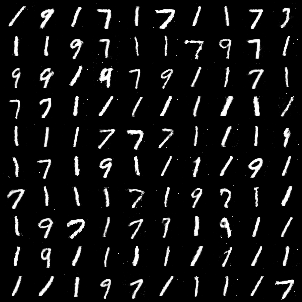

In [28]:
# show output after epochs training
Image.open(os.path.join(sample_dir, "fake_images-0300.png"))

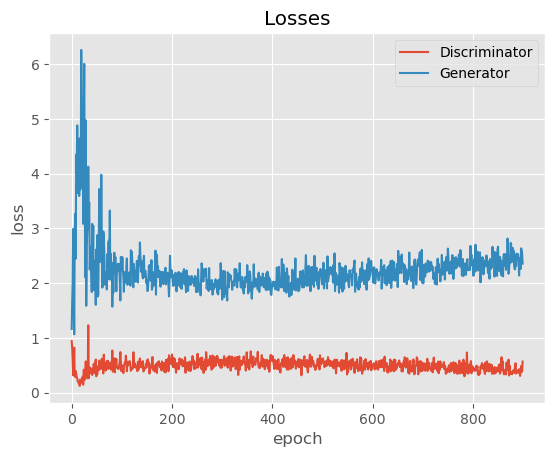

In [29]:
# show the discriminator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

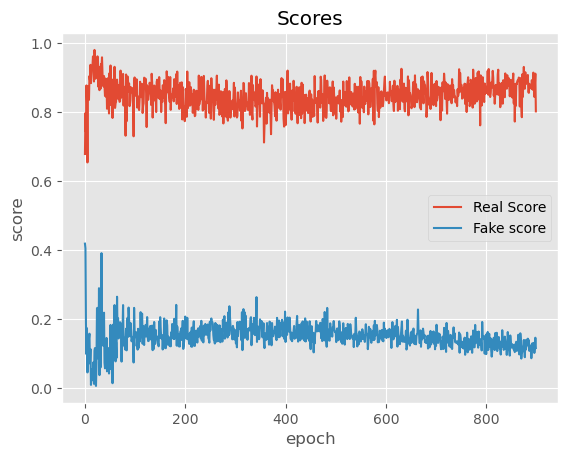

In [30]:
# plot the accuracy of discriminator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");

## 2. DCGAN

*Source: <a href="https://arxiv.org/pdf/1511.06434v2.pdf" target="_blank">Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015)</a>.*

The goal of this part is to enhance your results achieved in the part one with DCGAN. Feel free to reuse your code, improve architecture or training scheme, etc.

In [31]:
class CFG:
    batch_size = 128
    num_epochs = 300
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = "data"
    nc = 3  ## number of channels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images/"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

Files already downloaded and verified


Label:  6


(array([ 3.,  6., 52., 36.,  6.,  4., 12., 40., 40.,  7.,  2.,  6., 22.,
        32., 32.]),
 array([-0.87450981, -0.81124181, -0.74797386, -0.68470585, -0.62143791,
        -0.5581699 , -0.49490196, -0.43163398, -0.36836597, -0.305098  ,
        -0.24183004, -0.17856206, -0.11529408, -0.0520261 ,  0.01124188,
         0.07450986]),
 <BarContainer object of 15 artists>)

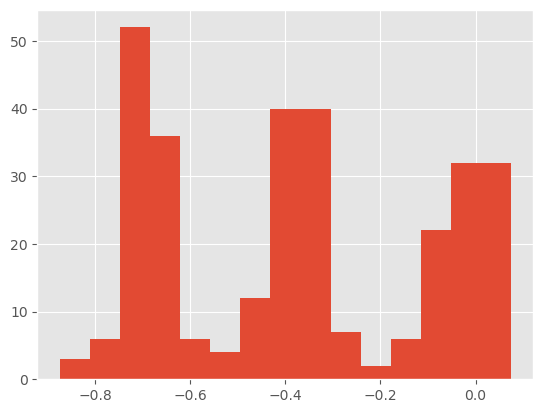

In [32]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


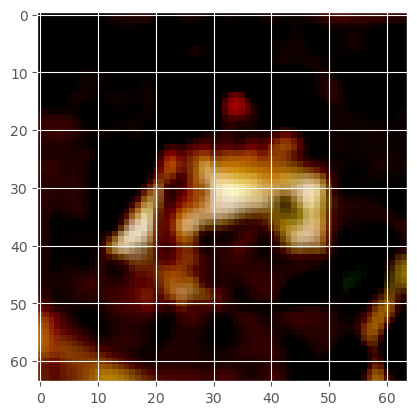

In [33]:
# show image sample with matplotlib

plt.imshow(np.transpose(img, (1, 2, 0)))

In [34]:
# create the dataloader
cifar_data_loader = DataLoader(dataset = cifar_dataset, shuffle = True, batch_size = CFG.batch_size)

### DCGAN implementation

In [35]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Next is a transposed convolution where typically you’d halve the depth and double the width and height of the previous layer.

In [36]:
class DCGenerator(nn.Module):
    def __init__(self, nc, nz, ngf):
        # ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu
        # ConvTranspose2d - BatchNorm - Relu - ConvTranspose2d - Tanh
        super(DCGenerator, self).__init__()
        ##
        self.model = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, kernel_size=(4, 4), stride=(1, 1), bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 4, ngf * 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 2, ngf, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf, nc, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.Tanh()
            
        )

    def forward(self, x):
        ##
        return self.model(x)


class DCDiscriminator(nn.Module):
    def __init__(self, nc, ndf):
        # conv2d - leaky - conv2d - batchnorm - leaky - conv2d - batchnorm - leaky - conv - batchnorm - leaky - conv2d
        super(DCDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(nc, ndf, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, 1, kernel_size=(4, 4), stride=(1, 1), bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [37]:
# create new Generator model
DCG = DCGenerator(CFG.nc, CFG.nz, CFG.ngf)
DCG.apply(weights_init)
DCG.to(device)

# create new Discriminator model
DCD = DCDiscriminator(CFG.nc, CFG.ndf)
DCD.apply(weights_init)
DCG.to(device)

DCGenerator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


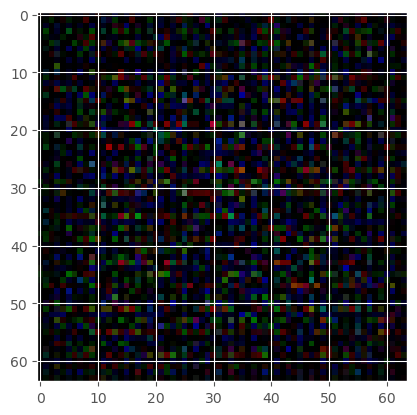

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


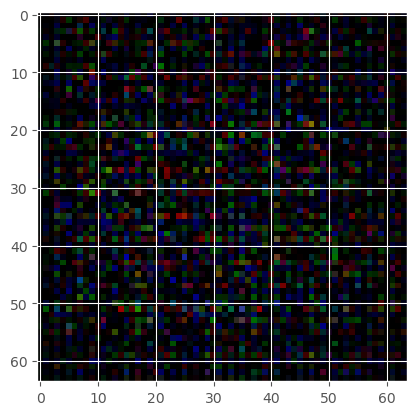

In [38]:
# show the output of model
y = DCG(torch.randn(2, CFG.nz, 1, 1).to(device))
plt.imshow(np.transpose(y.detach().cpu()[0].reshape(3, 64, 64), (1, 2, 0)))
plt.show()
plt.imshow(np.transpose(y.detach().cpu()[1].reshape(3, 64, 64), (1, 2, 0)))

In [39]:
# define the criterion is nn.BCELoss()
loss_fn = nn.BCELoss()
## Define the optimizer for generator and discriminator

g_optimizer = torch.optim.Adam(DCG.parameters(), lr=CFG.lr, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(DCD.parameters(), lr=CFG.lr, betas=(0.5, 0.999))

In [40]:
# feel free to reuse your training functions

### Start the training process

In [41]:
def save_fake_images_cifar(DCG_model, index, device=CFG.device, sample_dir=CFG.sample_dir, batch_size=CFG.batch_size):
    sample_vectors = torch.randn(batch_size, CFG.nz, 1, 1).to(device)
    fake_images = DCG_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = "DCG_fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(
        denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10
    )

In [42]:
from tqdm import tqdm

In [43]:
%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
DCG.to(CFG.device)
DCD.to(CFG.device)
for epoch in range(CFG.num_epochs):
    for i, (images, _) in tqdm(enumerate(cifar_data_loader)):
        if images.size() != torch.Size([128, 3, 64, 64]):
            continue
        # Load a batch & transform to vectors
        images = images.to(CFG.device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(DCD, DCG, images, batch_size=CFG.batch_size, latent_size=CFG.nz, additional_sizes=[1,1])
        # Train the generator
        g_loss, fake_images = train_generator(DCD, DCG, batch_size=CFG.batch_size, latent_size=CFG.nz, additional_sizes=[1,1])
        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    CFG.num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_cifar(DCG, (epoch + 1))
    
    

201it [00:37,  5.06it/s]

Epoch [0/300], Step [200/600], d_loss: 0.6300, g_loss: 7.0588, D(x): 0.84, D(G(z)): 0.27


391it [01:12,  5.41it/s]


Saving DCG_fake_images-0011.png


201it [00:36,  5.18it/s]

Epoch [1/300], Step [200/600], d_loss: 1.4145, g_loss: 6.9161, D(x): 0.85, D(G(z)): 0.61


391it [01:11,  5.48it/s]


Saving DCG_fake_images-0021.png


201it [00:36,  5.22it/s]

Epoch [2/300], Step [200/600], d_loss: 0.5081, g_loss: 3.4968, D(x): 0.83, D(G(z)): 0.23


391it [01:11,  5.47it/s]


Saving DCG_fake_images-0031.png


201it [00:36,  5.38it/s]

Epoch [3/300], Step [200/600], d_loss: 1.8222, g_loss: 2.1618, D(x): 0.27, D(G(z)): 0.01


391it [01:09,  5.59it/s]


Saving DCG_fake_images-0041.png


200it [00:35,  5.27it/s]

Epoch [4/300], Step [200/600], d_loss: 0.6308, g_loss: 3.7152, D(x): 0.86, D(G(z)): 0.34


391it [01:08,  5.69it/s]


Saving DCG_fake_images-0051.png


201it [00:36,  5.26it/s]

Epoch [5/300], Step [200/600], d_loss: 0.5876, g_loss: 3.0918, D(x): 0.85, D(G(z)): 0.31


391it [01:10,  5.55it/s]


Saving DCG_fake_images-0061.png


200it [00:37,  4.79it/s]

Epoch [6/300], Step [200/600], d_loss: 0.8532, g_loss: 1.8612, D(x): 0.51, D(G(z)): 0.05


391it [01:12,  5.40it/s]


Saving DCG_fake_images-0071.png


201it [00:37,  5.29it/s]

Epoch [7/300], Step [200/600], d_loss: 0.3242, g_loss: 2.7595, D(x): 0.83, D(G(z)): 0.11


391it [01:12,  5.38it/s]


Saving DCG_fake_images-0081.png


201it [00:35,  5.38it/s]

Epoch [8/300], Step [200/600], d_loss: 1.8948, g_loss: 4.8198, D(x): 0.99, D(G(z)): 0.79


391it [01:09,  5.65it/s]


Saving DCG_fake_images-0091.png


200it [00:37,  4.96it/s]

Epoch [9/300], Step [200/600], d_loss: 0.2334, g_loss: 4.1543, D(x): 0.92, D(G(z)): 0.12


391it [01:12,  5.42it/s]


Saving DCG_fake_images-0101.png


201it [00:37,  5.09it/s]

Epoch [10/300], Step [200/600], d_loss: 0.1726, g_loss: 3.3530, D(x): 0.93, D(G(z)): 0.09


391it [01:12,  5.41it/s]


Saving DCG_fake_images-0111.png


201it [00:37,  5.36it/s]

Epoch [11/300], Step [200/600], d_loss: 0.9399, g_loss: 2.2182, D(x): 0.80, D(G(z)): 0.47


391it [01:12,  5.43it/s]


Saving DCG_fake_images-0121.png


201it [00:37,  5.02it/s]

Epoch [12/300], Step [200/600], d_loss: 0.3578, g_loss: 2.7079, D(x): 0.81, D(G(z)): 0.12


391it [01:12,  5.40it/s]


Saving DCG_fake_images-0131.png


201it [00:37,  4.88it/s]

Epoch [13/300], Step [200/600], d_loss: 0.1205, g_loss: 3.8415, D(x): 0.92, D(G(z)): 0.03


391it [01:12,  5.42it/s]


Saving DCG_fake_images-0141.png


201it [00:37,  5.35it/s]

Epoch [14/300], Step [200/600], d_loss: 0.5795, g_loss: 5.5075, D(x): 0.99, D(G(z)): 0.40


391it [01:11,  5.47it/s]


Saving DCG_fake_images-0151.png


200it [00:36,  5.11it/s]

Epoch [15/300], Step [200/600], d_loss: 0.1918, g_loss: 4.1093, D(x): 0.95, D(G(z)): 0.12


391it [01:11,  5.46it/s]


Saving DCG_fake_images-0161.png


201it [00:36,  5.32it/s]

Epoch [16/300], Step [200/600], d_loss: 0.6348, g_loss: 2.0666, D(x): 0.59, D(G(z)): 0.04


391it [01:11,  5.48it/s]


Saving DCG_fake_images-0171.png


201it [00:36,  5.29it/s]

Epoch [17/300], Step [200/600], d_loss: 0.0747, g_loss: 3.5106, D(x): 0.95, D(G(z)): 0.02


391it [01:12,  5.39it/s]


Saving DCG_fake_images-0181.png


201it [00:36,  5.22it/s]

Epoch [18/300], Step [200/600], d_loss: 0.7614, g_loss: 2.7117, D(x): 0.54, D(G(z)): 0.05


391it [01:11,  5.49it/s]


Saving DCG_fake_images-0191.png


201it [00:36,  5.29it/s]

Epoch [19/300], Step [200/600], d_loss: 0.9859, g_loss: 1.6154, D(x): 0.65, D(G(z)): 0.35


391it [01:11,  5.46it/s]


Saving DCG_fake_images-0201.png


201it [00:36,  5.11it/s]

Epoch [20/300], Step [200/600], d_loss: 0.5908, g_loss: 2.8743, D(x): 0.60, D(G(z)): 0.01


391it [01:11,  5.44it/s]


Saving DCG_fake_images-0211.png


201it [00:37,  4.96it/s]

Epoch [21/300], Step [200/600], d_loss: 0.2890, g_loss: 3.2600, D(x): 0.78, D(G(z)): 0.02


391it [01:12,  5.40it/s]


Saving DCG_fake_images-0221.png


201it [00:37,  5.27it/s]

Epoch [22/300], Step [200/600], d_loss: 2.4301, g_loss: 3.5626, D(x): 0.96, D(G(z)): 0.87


391it [01:11,  5.48it/s]


Saving DCG_fake_images-0231.png


201it [00:35,  5.31it/s]

Epoch [23/300], Step [200/600], d_loss: 0.6756, g_loss: 2.0723, D(x): 0.58, D(G(z)): 0.07


391it [01:09,  5.60it/s]


Saving DCG_fake_images-0241.png


200it [00:36,  5.05it/s]

Epoch [24/300], Step [200/600], d_loss: 0.3158, g_loss: 3.6727, D(x): 0.80, D(G(z)): 0.06


391it [01:10,  5.52it/s]


Saving DCG_fake_images-0251.png


201it [00:36,  4.85it/s]

Epoch [25/300], Step [200/600], d_loss: 0.0207, g_loss: 4.9571, D(x): 1.00, D(G(z)): 0.02


391it [01:12,  5.41it/s]


Saving DCG_fake_images-0261.png


200it [00:35,  5.25it/s]

Epoch [26/300], Step [200/600], d_loss: 0.0079, g_loss: 6.2681, D(x): 1.00, D(G(z)): 0.00


391it [01:10,  5.58it/s]


Saving DCG_fake_images-0271.png


201it [00:35,  5.30it/s]

Epoch [27/300], Step [200/600], d_loss: 0.0510, g_loss: 5.8913, D(x): 0.99, D(G(z)): 0.04


391it [01:10,  5.58it/s]


Saving DCG_fake_images-0281.png


201it [00:36,  5.31it/s]

Epoch [28/300], Step [200/600], d_loss: 1.1565, g_loss: 3.7808, D(x): 0.80, D(G(z)): 0.32


391it [01:10,  5.52it/s]


Saving DCG_fake_images-0291.png


201it [00:36,  5.34it/s]

Epoch [29/300], Step [200/600], d_loss: 0.0660, g_loss: 4.3905, D(x): 0.97, D(G(z)): 0.03


391it [01:11,  5.49it/s]


Saving DCG_fake_images-0301.png


201it [00:37,  5.30it/s]

Epoch [30/300], Step [200/600], d_loss: 0.3970, g_loss: 2.7913, D(x): 0.87, D(G(z)): 0.20


391it [01:11,  5.48it/s]


Saving DCG_fake_images-0311.png


201it [00:36,  5.34it/s]

Epoch [31/300], Step [200/600], d_loss: 0.2489, g_loss: 3.3549, D(x): 0.91, D(G(z)): 0.13


391it [01:10,  5.54it/s]


Saving DCG_fake_images-0321.png


200it [00:36,  5.13it/s]

Epoch [32/300], Step [200/600], d_loss: 0.7449, g_loss: 0.1658, D(x): 0.63, D(G(z)): 0.16


391it [01:10,  5.54it/s]


Saving DCG_fake_images-0331.png


201it [00:36,  5.18it/s]

Epoch [33/300], Step [200/600], d_loss: 0.2693, g_loss: 3.5106, D(x): 0.80, D(G(z)): 0.02


391it [01:09,  5.59it/s]


Saving DCG_fake_images-0341.png


201it [00:37,  5.22it/s]

Epoch [34/300], Step [200/600], d_loss: 0.1383, g_loss: 5.3566, D(x): 1.00, D(G(z)): 0.12


391it [01:11,  5.45it/s]


Saving DCG_fake_images-0351.png


201it [00:39,  5.19it/s]

Epoch [35/300], Step [200/600], d_loss: 0.1587, g_loss: 4.1308, D(x): 0.93, D(G(z)): 0.08


391it [01:16,  5.12it/s]


Saving DCG_fake_images-0361.png


200it [00:38,  4.56it/s]

Epoch [36/300], Step [200/600], d_loss: 0.0195, g_loss: 5.4163, D(x): 0.99, D(G(z)): 0.01


391it [01:13,  5.29it/s]


Saving DCG_fake_images-0371.png


200it [00:39,  5.17it/s]

Epoch [37/300], Step [200/600], d_loss: 0.6119, g_loss: 1.7880, D(x): 0.72, D(G(z)): 0.20


391it [01:15,  5.20it/s]


Saving DCG_fake_images-0381.png


200it [00:36,  5.13it/s]

Epoch [38/300], Step [200/600], d_loss: 0.4809, g_loss: 2.2438, D(x): 0.81, D(G(z)): 0.19


391it [01:14,  5.25it/s]


Saving DCG_fake_images-0391.png


201it [00:50,  5.30it/s]

Epoch [39/300], Step [200/600], d_loss: 0.6126, g_loss: 2.2952, D(x): 0.76, D(G(z)): 0.23


391it [01:28,  4.44it/s]


Saving DCG_fake_images-0401.png


201it [00:44,  4.91it/s]

Epoch [40/300], Step [200/600], d_loss: 0.4199, g_loss: 2.4946, D(x): 0.79, D(G(z)): 0.13


391it [01:23,  4.66it/s]


Saving DCG_fake_images-0411.png


201it [00:39,  5.28it/s]

Epoch [41/300], Step [200/600], d_loss: 0.5315, g_loss: 2.0855, D(x): 0.80, D(G(z)): 0.20


391it [01:16,  5.12it/s]


Saving DCG_fake_images-0421.png


201it [00:42,  5.34it/s]

Epoch [42/300], Step [200/600], d_loss: 0.4265, g_loss: 2.4705, D(x): 0.85, D(G(z)): 0.20


391it [01:19,  4.93it/s]


Saving DCG_fake_images-0431.png


201it [00:39,  5.26it/s]

Epoch [43/300], Step [200/600], d_loss: 0.1529, g_loss: 2.7148, D(x): 0.94, D(G(z)): 0.08


391it [01:16,  5.08it/s]


Saving DCG_fake_images-0441.png


200it [00:39,  4.69it/s]

Epoch [44/300], Step [200/600], d_loss: 0.0220, g_loss: 5.8917, D(x): 0.98, D(G(z)): 0.00


391it [01:15,  5.15it/s]


Saving DCG_fake_images-0451.png


201it [00:44,  4.29it/s]

Epoch [45/300], Step [200/600], d_loss: 0.0299, g_loss: 6.7188, D(x): 0.97, D(G(z)): 0.00


391it [01:20,  4.87it/s]


Saving DCG_fake_images-0461.png


201it [00:37,  5.28it/s]

Epoch [46/300], Step [200/600], d_loss: 0.6874, g_loss: 1.0039, D(x): 0.58, D(G(z)): 0.03


391it [01:15,  5.20it/s]


Saving DCG_fake_images-0471.png


201it [00:38,  4.49it/s]

Epoch [47/300], Step [200/600], d_loss: 0.6868, g_loss: 1.8098, D(x): 0.87, D(G(z)): 0.38


391it [01:14,  5.25it/s]


Saving DCG_fake_images-0481.png


201it [00:39,  5.33it/s]

Epoch [48/300], Step [200/600], d_loss: 0.0678, g_loss: 3.9106, D(x): 0.97, D(G(z)): 0.03


391it [01:14,  5.22it/s]


Saving DCG_fake_images-0491.png


200it [00:38,  5.23it/s]

Epoch [49/300], Step [200/600], d_loss: 0.4408, g_loss: 3.0772, D(x): 0.92, D(G(z)): 0.27


391it [01:14,  5.25it/s]


Saving DCG_fake_images-0501.png


201it [00:40,  5.03it/s]

Epoch [50/300], Step [200/600], d_loss: 0.3659, g_loss: 2.6980, D(x): 0.90, D(G(z)): 0.21


391it [01:17,  5.06it/s]


Saving DCG_fake_images-0511.png


201it [00:41,  5.23it/s]

Epoch [51/300], Step [200/600], d_loss: 0.2456, g_loss: 2.5213, D(x): 0.87, D(G(z)): 0.09


391it [01:16,  5.11it/s]


Saving DCG_fake_images-0521.png


200it [00:39,  4.50it/s]

Epoch [52/300], Step [200/600], d_loss: 0.5111, g_loss: 2.9361, D(x): 0.77, D(G(z)): 0.17


391it [01:16,  5.08it/s]


Saving DCG_fake_images-0531.png


201it [00:36,  4.82it/s]

Epoch [53/300], Step [200/600], d_loss: 0.0018, g_loss: 7.3456, D(x): 1.00, D(G(z)): 0.00


391it [01:13,  5.35it/s]


Saving DCG_fake_images-0541.png


200it [00:38,  4.50it/s]

Epoch [54/300], Step [200/600], d_loss: 0.2249, g_loss: 2.8226, D(x): 0.89, D(G(z)): 0.09


391it [01:15,  5.20it/s]


Saving DCG_fake_images-0551.png


201it [00:39,  5.09it/s]

Epoch [55/300], Step [200/600], d_loss: 0.4237, g_loss: 1.7952, D(x): 0.71, D(G(z)): 0.02


391it [01:14,  5.22it/s]


Saving DCG_fake_images-0561.png


201it [00:37,  5.30it/s]

Epoch [56/300], Step [200/600], d_loss: 0.0191, g_loss: 6.8699, D(x): 0.98, D(G(z)): 0.00


391it [01:13,  5.35it/s]


Saving DCG_fake_images-0571.png


201it [00:41,  5.06it/s]

Epoch [57/300], Step [200/600], d_loss: 0.0086, g_loss: 6.0637, D(x): 1.00, D(G(z)): 0.00


391it [01:19,  4.89it/s]


Saving DCG_fake_images-0581.png


200it [00:39,  4.80it/s]

Epoch [58/300], Step [200/600], d_loss: 0.0303, g_loss: 4.9835, D(x): 0.98, D(G(z)): 0.01


391it [01:13,  5.35it/s]


Saving DCG_fake_images-0591.png


201it [00:40,  5.31it/s]

Epoch [59/300], Step [200/600], d_loss: 0.0730, g_loss: 4.3223, D(x): 0.99, D(G(z)): 0.06


391it [01:14,  5.24it/s]


Saving DCG_fake_images-0601.png


201it [00:36,  5.15it/s]

Epoch [60/300], Step [200/600], d_loss: 0.2746, g_loss: 2.4484, D(x): 0.89, D(G(z)): 0.13


391it [01:11,  5.50it/s]


Saving DCG_fake_images-0611.png


200it [00:39,  3.34it/s]

Epoch [61/300], Step [200/600], d_loss: 0.0397, g_loss: 4.9561, D(x): 0.99, D(G(z)): 0.03


391it [01:17,  5.06it/s]


Saving DCG_fake_images-0621.png


200it [00:44,  4.86it/s]

Epoch [62/300], Step [200/600], d_loss: 5.8372, g_loss: 3.0911, D(x): 1.00, D(G(z)): 0.99


391it [01:19,  4.94it/s]


Saving DCG_fake_images-0631.png


201it [00:38,  5.26it/s]

Epoch [63/300], Step [200/600], d_loss: 0.2725, g_loss: 3.1955, D(x): 0.91, D(G(z)): 0.15


391it [01:14,  5.27it/s]


Saving DCG_fake_images-0641.png


200it [00:36,  4.57it/s]

Epoch [64/300], Step [200/600], d_loss: 0.0156, g_loss: 5.6530, D(x): 0.99, D(G(z)): 0.01


391it [01:12,  5.38it/s]


Saving DCG_fake_images-0651.png


200it [00:36,  5.10it/s]

Epoch [65/300], Step [200/600], d_loss: 0.0161, g_loss: 4.8306, D(x): 0.99, D(G(z)): 0.01


391it [01:11,  5.49it/s]


Saving DCG_fake_images-0661.png


201it [00:36,  5.25it/s]

Epoch [66/300], Step [200/600], d_loss: 0.3947, g_loss: 4.2370, D(x): 0.95, D(G(z)): 0.26


391it [01:11,  5.47it/s]


Saving DCG_fake_images-0671.png


200it [00:38,  4.50it/s]

Epoch [67/300], Step [200/600], d_loss: 0.1831, g_loss: 3.8122, D(x): 0.85, D(G(z)): 0.01


391it [01:15,  5.20it/s]


Saving DCG_fake_images-0681.png


201it [00:38,  4.74it/s]

Epoch [68/300], Step [200/600], d_loss: 0.4858, g_loss: 4.6008, D(x): 0.66, D(G(z)): 0.00


391it [01:15,  5.21it/s]


Saving DCG_fake_images-0691.png


201it [00:39,  5.01it/s]

Epoch [69/300], Step [200/600], d_loss: 0.4476, g_loss: 0.9923, D(x): 0.70, D(G(z)): 0.03


391it [01:16,  5.14it/s]


Saving DCG_fake_images-0701.png


200it [00:42,  4.08it/s]

Epoch [70/300], Step [200/600], d_loss: 0.2959, g_loss: 2.9754, D(x): 0.84, D(G(z)): 0.08


391it [01:18,  4.96it/s]


Saving DCG_fake_images-0711.png


201it [00:42,  5.05it/s]

Epoch [71/300], Step [200/600], d_loss: 0.3813, g_loss: 2.3386, D(x): 0.81, D(G(z)): 0.13


391it [01:17,  5.06it/s]


Saving DCG_fake_images-0721.png


200it [00:36,  4.30it/s]

Epoch [72/300], Step [200/600], d_loss: 0.3539, g_loss: 2.6625, D(x): 0.83, D(G(z)): 0.14


391it [01:17,  5.03it/s]


Saving DCG_fake_images-0731.png


201it [00:37,  4.86it/s]

Epoch [73/300], Step [200/600], d_loss: 0.0305, g_loss: 4.4564, D(x): 0.99, D(G(z)): 0.02


391it [01:13,  5.33it/s]


Saving DCG_fake_images-0741.png


201it [00:36,  5.27it/s]

Epoch [74/300], Step [200/600], d_loss: 0.0438, g_loss: 4.7285, D(x): 1.00, D(G(z)): 0.04


391it [01:12,  5.40it/s]


Saving DCG_fake_images-0751.png


201it [00:37,  5.14it/s]

Epoch [75/300], Step [200/600], d_loss: 0.0163, g_loss: 6.5268, D(x): 0.99, D(G(z)): 0.00


391it [01:12,  5.40it/s]


Saving DCG_fake_images-0761.png


201it [00:36,  5.31it/s]

Epoch [76/300], Step [200/600], d_loss: 0.2144, g_loss: 3.2165, D(x): 0.88, D(G(z)): 0.07


391it [01:12,  5.41it/s]


Saving DCG_fake_images-0771.png


201it [00:41,  4.68it/s]

Epoch [77/300], Step [200/600], d_loss: 1.8180, g_loss: 4.4135, D(x): 0.95, D(G(z)): 0.72


391it [01:19,  4.94it/s]


Saving DCG_fake_images-0781.png


200it [00:37,  5.18it/s]

Epoch [78/300], Step [200/600], d_loss: 0.1954, g_loss: 3.3751, D(x): 0.86, D(G(z)): 0.03


391it [01:14,  5.27it/s]


Saving DCG_fake_images-0791.png


200it [00:39,  5.16it/s]

Epoch [79/300], Step [200/600], d_loss: 0.3873, g_loss: 2.5575, D(x): 0.82, D(G(z)): 0.14


391it [01:15,  5.18it/s]


Saving DCG_fake_images-0801.png


200it [00:37,  4.85it/s]

Epoch [80/300], Step [200/600], d_loss: 0.0748, g_loss: 4.2189, D(x): 0.96, D(G(z)): 0.02


391it [01:15,  5.20it/s]


Saving DCG_fake_images-0811.png


201it [00:37,  5.28it/s]

Epoch [81/300], Step [200/600], d_loss: 0.2349, g_loss: 3.0763, D(x): 0.85, D(G(z)): 0.05


391it [01:14,  5.25it/s]


Saving DCG_fake_images-0821.png


201it [00:39,  5.21it/s]

Epoch [82/300], Step [200/600], d_loss: 0.3779, g_loss: 2.1074, D(x): 0.86, D(G(z)): 0.17


391it [01:16,  5.13it/s]


Saving DCG_fake_images-0831.png


201it [00:38,  5.17it/s]

Epoch [83/300], Step [200/600], d_loss: 0.0103, g_loss: 7.0638, D(x): 0.99, D(G(z)): 0.00


391it [01:14,  5.24it/s]


Saving DCG_fake_images-0841.png


201it [00:38,  4.94it/s]

Epoch [84/300], Step [200/600], d_loss: 0.1981, g_loss: 3.5481, D(x): 0.89, D(G(z)): 0.07


391it [01:15,  5.15it/s]


Saving DCG_fake_images-0851.png


201it [00:37,  5.22it/s]

Epoch [85/300], Step [200/600], d_loss: 0.3110, g_loss: 2.3693, D(x): 0.78, D(G(z)): 0.02


391it [01:13,  5.31it/s]


Saving DCG_fake_images-0861.png


201it [00:38,  5.26it/s]

Epoch [86/300], Step [200/600], d_loss: 0.2150, g_loss: 4.2759, D(x): 0.99, D(G(z)): 0.17


391it [01:15,  5.15it/s]


Saving DCG_fake_images-0871.png


201it [00:38,  4.98it/s]

Epoch [87/300], Step [200/600], d_loss: 0.1117, g_loss: 5.1344, D(x): 1.00, D(G(z)): 0.10


391it [01:15,  5.19it/s]


Saving DCG_fake_images-0881.png


200it [00:39,  4.67it/s]

Epoch [88/300], Step [200/600], d_loss: 0.1499, g_loss: 2.9960, D(x): 0.93, D(G(z)): 0.06


391it [01:17,  5.03it/s]


Saving DCG_fake_images-0891.png


201it [00:37,  5.33it/s]

Epoch [89/300], Step [200/600], d_loss: 0.7397, g_loss: 1.9707, D(x): 0.84, D(G(z)): 0.33


391it [01:11,  5.44it/s]


Saving DCG_fake_images-0901.png


200it [00:36,  4.98it/s]

Epoch [90/300], Step [200/600], d_loss: 0.1367, g_loss: 3.3279, D(x): 0.91, D(G(z)): 0.04


391it [01:12,  5.42it/s]


Saving DCG_fake_images-0911.png


201it [00:37,  5.31it/s]

Epoch [91/300], Step [200/600], d_loss: 0.4584, g_loss: 2.0543, D(x): 0.72, D(G(z)): 0.08


391it [01:15,  5.20it/s]


Saving DCG_fake_images-0921.png


201it [00:40,  5.21it/s]

Epoch [92/300], Step [200/600], d_loss: 0.0071, g_loss: 7.8212, D(x): 0.99, D(G(z)): 0.00


391it [01:16,  5.12it/s]


Saving DCG_fake_images-0931.png


200it [00:38,  4.27it/s]

Epoch [93/300], Step [200/600], d_loss: 0.0389, g_loss: 5.1739, D(x): 0.97, D(G(z)): 0.01


391it [01:17,  5.07it/s]


Saving DCG_fake_images-0941.png


201it [00:38,  4.93it/s]

Epoch [94/300], Step [200/600], d_loss: 0.0041, g_loss: 7.6074, D(x): 1.00, D(G(z)): 0.00


391it [01:13,  5.33it/s]


Saving DCG_fake_images-0951.png


201it [00:36,  5.21it/s]

Epoch [95/300], Step [200/600], d_loss: 0.2357, g_loss: 3.2581, D(x): 0.90, D(G(z)): 0.10


391it [01:13,  5.31it/s]


Saving DCG_fake_images-0961.png


201it [00:39,  5.31it/s]

Epoch [96/300], Step [200/600], d_loss: 0.2695, g_loss: 2.7642, D(x): 0.84, D(G(z)): 0.07


391it [01:14,  5.22it/s]


Saving DCG_fake_images-0971.png


201it [00:37,  5.28it/s]

Epoch [97/300], Step [200/600], d_loss: 0.0962, g_loss: 5.6425, D(x): 1.00, D(G(z)): 0.08


391it [01:13,  5.30it/s]


Saving DCG_fake_images-0981.png


200it [00:38,  4.30it/s]

Epoch [98/300], Step [200/600], d_loss: 0.0606, g_loss: 4.2313, D(x): 0.97, D(G(z)): 0.03


391it [01:14,  5.25it/s]


Saving DCG_fake_images-0991.png


200it [00:38,  5.17it/s]

Epoch [99/300], Step [200/600], d_loss: 0.0118, g_loss: 5.8232, D(x): 1.00, D(G(z)): 0.01


391it [01:13,  5.33it/s]


Saving DCG_fake_images-1001.png


201it [00:36,  5.30it/s]

Epoch [100/300], Step [200/600], d_loss: 2.0763, g_loss: 1.7058, D(x): 0.25, D(G(z)): 0.01


391it [01:12,  5.43it/s]


Saving DCG_fake_images-1011.png


201it [00:36,  5.30it/s]

Epoch [101/300], Step [200/600], d_loss: 0.0218, g_loss: 5.8729, D(x): 1.00, D(G(z)): 0.02


391it [01:13,  5.32it/s]


Saving DCG_fake_images-1021.png


200it [00:38,  4.64it/s]

Epoch [102/300], Step [200/600], d_loss: 0.0022, g_loss: 7.1820, D(x): 1.00, D(G(z)): 0.00


391it [01:14,  5.22it/s]


Saving DCG_fake_images-1031.png


200it [00:39,  4.62it/s]

Epoch [103/300], Step [200/600], d_loss: 0.8451, g_loss: 4.9032, D(x): 1.00, D(G(z)): 0.50


391it [01:16,  5.09it/s]


Saving DCG_fake_images-1041.png


201it [00:39,  5.00it/s]

Epoch [104/300], Step [200/600], d_loss: 0.0102, g_loss: 6.7720, D(x): 1.00, D(G(z)): 0.01


391it [01:13,  5.30it/s]


Saving DCG_fake_images-1051.png


201it [00:39,  4.55it/s]

Epoch [105/300], Step [200/600], d_loss: 0.1435, g_loss: 4.9444, D(x): 0.99, D(G(z)): 0.12


391it [01:21,  4.80it/s]


Saving DCG_fake_images-1061.png


200it [00:45,  4.13it/s]

Epoch [106/300], Step [200/600], d_loss: 0.2840, g_loss: 4.3351, D(x): 0.81, D(G(z)): 0.04


391it [01:27,  4.47it/s]


Saving DCG_fake_images-1071.png


200it [00:38,  4.74it/s]

Epoch [107/300], Step [200/600], d_loss: 0.1070, g_loss: 4.1983, D(x): 0.98, D(G(z)): 0.08


391it [01:16,  5.09it/s]


Saving DCG_fake_images-1081.png


200it [00:39,  3.92it/s]

Epoch [108/300], Step [200/600], d_loss: 0.0100, g_loss: 6.6021, D(x): 0.99, D(G(z)): 0.00


391it [01:15,  5.15it/s]


Saving DCG_fake_images-1091.png


200it [00:38,  4.84it/s]

Epoch [109/300], Step [200/600], d_loss: 0.1664, g_loss: 4.6997, D(x): 0.94, D(G(z)): 0.09


391it [01:15,  5.18it/s]


Saving DCG_fake_images-1101.png


200it [00:37,  4.68it/s]

Epoch [110/300], Step [200/600], d_loss: 0.1366, g_loss: 3.6375, D(x): 0.92, D(G(z)): 0.04


391it [01:14,  5.21it/s]


Saving DCG_fake_images-1111.png


201it [00:40,  4.94it/s]

Epoch [111/300], Step [200/600], d_loss: 0.1365, g_loss: 2.6584, D(x): 0.96, D(G(z)): 0.08


391it [01:16,  5.08it/s]


Saving DCG_fake_images-1121.png


201it [00:37,  4.97it/s]

Epoch [112/300], Step [200/600], d_loss: 0.0523, g_loss: 4.5207, D(x): 0.99, D(G(z)): 0.04


391it [01:16,  5.12it/s]


Saving DCG_fake_images-1131.png


200it [00:40,  4.99it/s]

Epoch [113/300], Step [200/600], d_loss: 0.3459, g_loss: 2.9956, D(x): 0.93, D(G(z)): 0.20


391it [01:16,  5.12it/s]


Saving DCG_fake_images-1141.png


201it [00:37,  4.77it/s]

Epoch [114/300], Step [200/600], d_loss: 0.3769, g_loss: 2.4902, D(x): 0.78, D(G(z)): 0.09


391it [01:14,  5.24it/s]


Saving DCG_fake_images-1151.png


201it [00:39,  5.21it/s]

Epoch [115/300], Step [200/600], d_loss: 0.0167, g_loss: 7.5726, D(x): 0.99, D(G(z)): 0.00


391it [01:16,  5.08it/s]


Saving DCG_fake_images-1161.png


200it [00:38,  4.29it/s]

Epoch [116/300], Step [200/600], d_loss: 0.2248, g_loss: 3.1571, D(x): 0.92, D(G(z)): 0.10


391it [01:17,  5.02it/s]


Saving DCG_fake_images-1171.png


201it [00:39,  4.50it/s]

Epoch [117/300], Step [200/600], d_loss: 0.1725, g_loss: 3.3658, D(x): 0.95, D(G(z)): 0.10


391it [01:15,  5.15it/s]


Saving DCG_fake_images-1181.png


201it [00:38,  5.32it/s]

Epoch [118/300], Step [200/600], d_loss: 0.1096, g_loss: 4.3344, D(x): 0.91, D(G(z)): 0.01


391it [01:13,  5.31it/s]


Saving DCG_fake_images-1191.png


201it [00:38,  5.32it/s]

Epoch [119/300], Step [200/600], d_loss: 0.0321, g_loss: 4.9178, D(x): 0.99, D(G(z)): 0.02


391it [01:13,  5.33it/s]


Saving DCG_fake_images-1201.png


201it [00:38,  4.86it/s]

Epoch [120/300], Step [200/600], d_loss: 0.0773, g_loss: 4.7066, D(x): 0.94, D(G(z)): 0.01


391it [01:14,  5.28it/s]


Saving DCG_fake_images-1211.png


201it [00:38,  5.35it/s]

Epoch [121/300], Step [200/600], d_loss: 0.0917, g_loss: 4.9425, D(x): 0.94, D(G(z)): 0.02


391it [01:14,  5.21it/s]


Saving DCG_fake_images-1221.png


201it [00:39,  5.31it/s]

Epoch [122/300], Step [200/600], d_loss: 0.2616, g_loss: 3.8449, D(x): 0.83, D(G(z)): 0.05


391it [01:14,  5.28it/s]


Saving DCG_fake_images-1231.png


201it [00:37,  5.31it/s]

Epoch [123/300], Step [200/600], d_loss: 0.2751, g_loss: 3.0000, D(x): 0.86, D(G(z)): 0.09


391it [01:14,  5.27it/s]


Saving DCG_fake_images-1241.png


201it [00:37,  5.28it/s]

Epoch [124/300], Step [200/600], d_loss: 0.0499, g_loss: 4.6108, D(x): 0.98, D(G(z)): 0.03


391it [01:11,  5.44it/s]


Saving DCG_fake_images-1251.png


201it [00:39,  4.89it/s]

Epoch [125/300], Step [200/600], d_loss: 0.1651, g_loss: 4.3219, D(x): 0.99, D(G(z)): 0.12


391it [01:16,  5.11it/s]


Saving DCG_fake_images-1261.png


200it [00:42,  3.42it/s]

Epoch [126/300], Step [200/600], d_loss: 0.2531, g_loss: 4.1403, D(x): 0.98, D(G(z)): 0.18


391it [01:21,  4.80it/s]


Saving DCG_fake_images-1271.png


201it [00:40,  5.26it/s]

Epoch [127/300], Step [200/600], d_loss: 0.2308, g_loss: 3.3367, D(x): 0.97, D(G(z)): 0.16


391it [01:28,  4.41it/s]


Saving DCG_fake_images-1281.png


200it [00:49,  3.38it/s]

Epoch [128/300], Step [200/600], d_loss: 1.3275, g_loss: 3.5745, D(x): 0.83, D(G(z)): 0.48


391it [01:39,  3.93it/s]


Saving DCG_fake_images-1291.png


201it [00:53,  5.35it/s]

Epoch [129/300], Step [200/600], d_loss: 0.3665, g_loss: 3.4952, D(x): 0.92, D(G(z)): 0.21


391it [01:28,  4.43it/s]


Saving DCG_fake_images-1301.png


201it [00:38,  4.93it/s]

Epoch [130/300], Step [200/600], d_loss: 0.0055, g_loss: 7.6153, D(x): 1.00, D(G(z)): 0.00


391it [01:15,  5.21it/s]


Saving DCG_fake_images-1311.png


201it [00:39,  5.21it/s]

Epoch [131/300], Step [200/600], d_loss: 0.2103, g_loss: 3.0787, D(x): 0.92, D(G(z)): 0.10


391it [01:14,  5.22it/s]


Saving DCG_fake_images-1321.png


201it [00:38,  5.31it/s]

Epoch [132/300], Step [200/600], d_loss: 0.0785, g_loss: 4.6194, D(x): 0.98, D(G(z)): 0.04


391it [01:13,  5.34it/s]


Saving DCG_fake_images-1331.png


201it [00:36,  5.24it/s]

Epoch [133/300], Step [200/600], d_loss: 0.1998, g_loss: 2.7362, D(x): 0.88, D(G(z)): 0.06


391it [01:12,  5.43it/s]


Saving DCG_fake_images-1341.png


201it [00:36,  5.17it/s]

Epoch [134/300], Step [200/600], d_loss: 0.2400, g_loss: 2.3609, D(x): 0.85, D(G(z)): 0.05


391it [01:11,  5.45it/s]


Saving DCG_fake_images-1351.png


201it [00:37,  5.22it/s]

Epoch [135/300], Step [200/600], d_loss: 0.0160, g_loss: 5.9923, D(x): 1.00, D(G(z)): 0.01


391it [01:11,  5.45it/s]


Saving DCG_fake_images-1361.png


201it [00:36,  5.20it/s]

Epoch [136/300], Step [200/600], d_loss: 0.1964, g_loss: 3.3228, D(x): 0.87, D(G(z)): 0.04


391it [01:11,  5.46it/s]


Saving DCG_fake_images-1371.png


201it [00:36,  5.22it/s]

Epoch [137/300], Step [200/600], d_loss: 0.1652, g_loss: 3.4152, D(x): 0.96, D(G(z)): 0.11


391it [01:11,  5.47it/s]


Saving DCG_fake_images-1381.png


201it [00:36,  5.19it/s]

Epoch [138/300], Step [200/600], d_loss: 0.1981, g_loss: 3.5344, D(x): 0.91, D(G(z)): 0.07


391it [01:11,  5.46it/s]


Saving DCG_fake_images-1391.png


201it [00:36,  5.18it/s]

Epoch [139/300], Step [200/600], d_loss: 0.1210, g_loss: 3.0193, D(x): 0.91, D(G(z)): 0.02


391it [01:11,  5.46it/s]


Saving DCG_fake_images-1401.png


200it [00:36,  5.07it/s]

Epoch [140/300], Step [200/600], d_loss: 0.2533, g_loss: 4.9346, D(x): 0.98, D(G(z)): 0.18


391it [01:11,  5.46it/s]


Saving DCG_fake_images-1411.png


201it [00:36,  5.16it/s]

Epoch [141/300], Step [200/600], d_loss: 0.1808, g_loss: 2.8097, D(x): 0.89, D(G(z)): 0.04


391it [01:11,  5.44it/s]


Saving DCG_fake_images-1421.png


201it [00:36,  5.30it/s]

Epoch [142/300], Step [200/600], d_loss: 0.9322, g_loss: 2.5859, D(x): 0.50, D(G(z)): 0.02


391it [01:10,  5.54it/s]


Saving DCG_fake_images-1431.png


201it [00:36,  5.29it/s]

Epoch [143/300], Step [200/600], d_loss: 0.0099, g_loss: 7.3300, D(x): 0.99, D(G(z)): 0.00


391it [01:11,  5.49it/s]


Saving DCG_fake_images-1441.png


201it [00:36,  5.22it/s]

Epoch [144/300], Step [200/600], d_loss: 0.0126, g_loss: 6.8718, D(x): 1.00, D(G(z)): 0.01


391it [01:11,  5.47it/s]


Saving DCG_fake_images-1451.png


201it [00:37,  5.38it/s]

Epoch [145/300], Step [200/600], d_loss: 1.6691, g_loss: 1.5118, D(x): 0.34, D(G(z)): 0.00


391it [01:10,  5.51it/s]


Saving DCG_fake_images-1461.png


201it [00:36,  5.38it/s]

Epoch [146/300], Step [200/600], d_loss: 0.0074, g_loss: 6.9936, D(x): 1.00, D(G(z)): 0.01


391it [01:11,  5.44it/s]


Saving DCG_fake_images-1471.png


200it [00:38,  4.61it/s]

Epoch [147/300], Step [200/600], d_loss: 0.0380, g_loss: 4.3275, D(x): 0.98, D(G(z)): 0.01


391it [01:15,  5.15it/s]


Saving DCG_fake_images-1481.png


200it [00:35,  4.97it/s]

Epoch [148/300], Step [200/600], d_loss: 0.0530, g_loss: 5.3746, D(x): 0.99, D(G(z)): 0.04


391it [01:10,  5.57it/s]


Saving DCG_fake_images-1491.png


201it [00:36,  5.38it/s]

Epoch [149/300], Step [200/600], d_loss: 0.2316, g_loss: 3.6801, D(x): 0.91, D(G(z)): 0.11


391it [01:10,  5.54it/s]


Saving DCG_fake_images-1501.png


201it [00:36,  5.32it/s]

Epoch [150/300], Step [200/600], d_loss: 0.0762, g_loss: 4.9050, D(x): 0.98, D(G(z)): 0.05


391it [01:10,  5.54it/s]


Saving DCG_fake_images-1511.png


201it [00:36,  5.34it/s]

Epoch [151/300], Step [200/600], d_loss: 0.0484, g_loss: 6.7092, D(x): 0.99, D(G(z)): 0.03


391it [01:10,  5.51it/s]


Saving DCG_fake_images-1521.png


201it [00:36,  5.30it/s]

Epoch [152/300], Step [200/600], d_loss: 0.2414, g_loss: 2.2732, D(x): 0.86, D(G(z)): 0.06


391it [01:11,  5.49it/s]


Saving DCG_fake_images-1531.png


201it [00:35,  5.34it/s]

Epoch [153/300], Step [200/600], d_loss: 0.2624, g_loss: 3.3477, D(x): 0.85, D(G(z)): 0.06


391it [01:09,  5.61it/s]


Saving DCG_fake_images-1541.png


201it [00:36,  5.37it/s]

Epoch [154/300], Step [200/600], d_loss: 0.0147, g_loss: 6.5421, D(x): 0.99, D(G(z)): 0.01


391it [01:10,  5.58it/s]


Saving DCG_fake_images-1551.png


201it [00:36,  5.28it/s]

Epoch [155/300], Step [200/600], d_loss: 0.1607, g_loss: 5.0110, D(x): 0.94, D(G(z)): 0.07


391it [01:10,  5.56it/s]


Saving DCG_fake_images-1561.png


201it [00:36,  5.27it/s]

Epoch [156/300], Step [200/600], d_loss: 0.1721, g_loss: 3.8373, D(x): 0.90, D(G(z)): 0.05


391it [01:10,  5.56it/s]


Saving DCG_fake_images-1571.png


201it [00:36,  5.22it/s]

Epoch [157/300], Step [200/600], d_loss: 0.0115, g_loss: 6.5508, D(x): 0.99, D(G(z)): 0.01


391it [01:10,  5.52it/s]


Saving DCG_fake_images-1581.png


201it [00:36,  5.41it/s]

Epoch [158/300], Step [200/600], d_loss: 0.0072, g_loss: 6.5780, D(x): 1.00, D(G(z)): 0.01


391it [01:09,  5.59it/s]


Saving DCG_fake_images-1591.png


201it [00:36,  5.26it/s]

Epoch [159/300], Step [200/600], d_loss: 0.2085, g_loss: 5.9183, D(x): 0.98, D(G(z)): 0.14


391it [01:10,  5.54it/s]


Saving DCG_fake_images-1601.png


201it [00:36,  5.26it/s]

Epoch [160/300], Step [200/600], d_loss: 0.0388, g_loss: 5.1965, D(x): 0.99, D(G(z)): 0.03


391it [01:10,  5.52it/s]


Saving DCG_fake_images-1611.png


201it [00:36,  5.17it/s]

Epoch [161/300], Step [200/600], d_loss: 0.0115, g_loss: 7.4495, D(x): 0.99, D(G(z)): 0.00


391it [01:10,  5.55it/s]


Saving DCG_fake_images-1621.png


201it [00:35,  5.35it/s]

Epoch [162/300], Step [200/600], d_loss: 0.1227, g_loss: 3.1418, D(x): 0.94, D(G(z)): 0.05


391it [01:09,  5.63it/s]


Saving DCG_fake_images-1631.png


201it [00:35,  5.35it/s]

Epoch [163/300], Step [200/600], d_loss: 0.0065, g_loss: 7.7894, D(x): 0.99, D(G(z)): 0.00


391it [01:09,  5.64it/s]


Saving DCG_fake_images-1641.png


200it [00:35,  5.25it/s]

Epoch [164/300], Step [200/600], d_loss: 0.2113, g_loss: 2.9266, D(x): 0.85, D(G(z)): 0.02


391it [01:09,  5.67it/s]


Saving DCG_fake_images-1651.png


201it [00:35,  5.36it/s]

Epoch [165/300], Step [200/600], d_loss: 2.4231, g_loss: 5.9241, D(x): 0.99, D(G(z)): 0.79


391it [01:09,  5.66it/s]


Saving DCG_fake_images-1661.png


201it [00:35,  5.40it/s]

Epoch [166/300], Step [200/600], d_loss: 0.0103, g_loss: 6.5077, D(x): 1.00, D(G(z)): 0.01


391it [01:09,  5.66it/s]


Saving DCG_fake_images-1671.png


200it [00:35,  5.27it/s]

Epoch [167/300], Step [200/600], d_loss: 0.0230, g_loss: 5.5145, D(x): 1.00, D(G(z)): 0.02


391it [01:09,  5.66it/s]


Saving DCG_fake_images-1681.png


201it [00:35,  5.38it/s]

Epoch [168/300], Step [200/600], d_loss: 0.0142, g_loss: 5.9008, D(x): 0.99, D(G(z)): 0.01


391it [01:09,  5.65it/s]


Saving DCG_fake_images-1691.png


201it [00:35,  5.35it/s]

Epoch [169/300], Step [200/600], d_loss: 0.2479, g_loss: 4.8810, D(x): 0.92, D(G(z)): 0.11


391it [01:09,  5.63it/s]


Saving DCG_fake_images-1701.png


201it [00:35,  5.39it/s]

Epoch [170/300], Step [200/600], d_loss: 0.0102, g_loss: 6.5065, D(x): 1.00, D(G(z)): 0.01


391it [01:09,  5.66it/s]


Saving DCG_fake_images-1711.png


201it [00:35,  5.40it/s]

Epoch [171/300], Step [200/600], d_loss: 0.2818, g_loss: 4.0298, D(x): 0.91, D(G(z)): 0.13


391it [01:09,  5.64it/s]


Saving DCG_fake_images-1721.png


201it [00:35,  5.37it/s]

Epoch [172/300], Step [200/600], d_loss: 0.0995, g_loss: 3.9580, D(x): 0.98, D(G(z)): 0.08


391it [01:09,  5.66it/s]


Saving DCG_fake_images-1731.png


201it [00:35,  5.37it/s]

Epoch [173/300], Step [200/600], d_loss: 0.0104, g_loss: 5.6227, D(x): 0.99, D(G(z)): 0.00


391it [01:09,  5.66it/s]


Saving DCG_fake_images-1741.png


200it [00:35,  5.24it/s]

Epoch [174/300], Step [200/600], d_loss: 0.5015, g_loss: 4.0630, D(x): 0.98, D(G(z)): 0.31


391it [01:09,  5.65it/s]


Saving DCG_fake_images-1751.png


201it [00:35,  5.38it/s]

Epoch [175/300], Step [200/600], d_loss: 0.0116, g_loss: 8.0134, D(x): 0.99, D(G(z)): 0.00


391it [01:09,  5.66it/s]


Saving DCG_fake_images-1761.png


200it [00:35,  5.29it/s]

Epoch [176/300], Step [200/600], d_loss: 0.1669, g_loss: 4.7262, D(x): 0.94, D(G(z)): 0.08


391it [01:08,  5.67it/s]


Saving DCG_fake_images-1771.png


201it [00:35,  5.42it/s]

Epoch [177/300], Step [200/600], d_loss: 0.3663, g_loss: 5.6620, D(x): 0.92, D(G(z)): 0.19


391it [01:08,  5.69it/s]


Saving DCG_fake_images-1781.png


201it [00:35,  5.40it/s]

Epoch [178/300], Step [200/600], d_loss: 0.0117, g_loss: 6.4152, D(x): 1.00, D(G(z)): 0.01


391it [01:08,  5.69it/s]


Saving DCG_fake_images-1791.png


201it [00:35,  5.40it/s]

Epoch [179/300], Step [200/600], d_loss: 0.0356, g_loss: 4.3211, D(x): 0.98, D(G(z)): 0.02


391it [01:08,  5.68it/s]


Saving DCG_fake_images-1801.png


201it [00:35,  5.42it/s]

Epoch [180/300], Step [200/600], d_loss: 0.0031, g_loss: 7.1160, D(x): 1.00, D(G(z)): 0.00


391it [01:08,  5.69it/s]


Saving DCG_fake_images-1811.png


201it [00:35,  5.41it/s]

Epoch [181/300], Step [200/600], d_loss: 0.1612, g_loss: 5.3901, D(x): 0.92, D(G(z)): 0.06


391it [01:08,  5.69it/s]


Saving DCG_fake_images-1821.png


201it [00:35,  5.36it/s]

Epoch [182/300], Step [200/600], d_loss: 0.0332, g_loss: 4.8999, D(x): 0.97, D(G(z)): 0.00


391it [01:08,  5.68it/s]


Saving DCG_fake_images-1831.png


201it [00:35,  5.40it/s]

Epoch [183/300], Step [200/600], d_loss: 0.0007, g_loss: 8.9416, D(x): 1.00, D(G(z)): 0.00


391it [01:09,  5.65it/s]


Saving DCG_fake_images-1841.png


201it [00:35,  5.37it/s]

Epoch [184/300], Step [200/600], d_loss: 0.0821, g_loss: 5.4838, D(x): 0.98, D(G(z)): 0.05


391it [01:08,  5.67it/s]


Saving DCG_fake_images-1851.png


201it [00:35,  5.39it/s]

Epoch [185/300], Step [200/600], d_loss: 0.3799, g_loss: 5.6408, D(x): 0.96, D(G(z)): 0.22


391it [01:08,  5.67it/s]


Saving DCG_fake_images-1861.png


200it [00:35,  5.29it/s]

Epoch [186/300], Step [200/600], d_loss: 6.1746, g_loss: 0.1448, D(x): 0.01, D(G(z)): 0.00


391it [01:09,  5.66it/s]


Saving DCG_fake_images-1871.png


200it [00:35,  5.29it/s]

Epoch [187/300], Step [200/600], d_loss: 0.0078, g_loss: 7.3843, D(x): 1.00, D(G(z)): 0.00


391it [01:09,  5.66it/s]


Saving DCG_fake_images-1881.png


201it [00:35,  5.39it/s]

Epoch [188/300], Step [200/600], d_loss: 0.3842, g_loss: 4.0971, D(x): 0.98, D(G(z)): 0.24


391it [01:09,  5.66it/s]


Saving DCG_fake_images-1891.png


201it [00:35,  5.38it/s]

Epoch [189/300], Step [200/600], d_loss: 0.0235, g_loss: 6.2446, D(x): 1.00, D(G(z)): 0.02


391it [01:09,  5.66it/s]


Saving DCG_fake_images-1901.png


201it [00:35,  5.39it/s]

Epoch [190/300], Step [200/600], d_loss: 0.1431, g_loss: 3.5921, D(x): 0.98, D(G(z)): 0.09


391it [01:09,  5.66it/s]


Saving DCG_fake_images-1911.png


201it [00:35,  5.39it/s]

Epoch [191/300], Step [200/600], d_loss: 0.0914, g_loss: 3.9415, D(x): 0.96, D(G(z)): 0.05


391it [01:09,  5.65it/s]


Saving DCG_fake_images-1921.png


200it [00:35,  5.28it/s]

Epoch [192/300], Step [200/600], d_loss: 0.0068, g_loss: 6.3885, D(x): 1.00, D(G(z)): 0.00


391it [01:09,  5.66it/s]


Saving DCG_fake_images-1931.png


200it [00:35,  5.29it/s]

Epoch [193/300], Step [200/600], d_loss: 0.0019, g_loss: 7.7403, D(x): 1.00, D(G(z)): 0.00


391it [01:09,  5.67it/s]


Saving DCG_fake_images-1941.png


201it [00:35,  5.38it/s]

Epoch [194/300], Step [200/600], d_loss: 0.1662, g_loss: 4.4199, D(x): 0.96, D(G(z)): 0.09


391it [01:09,  5.66it/s]


Saving DCG_fake_images-1951.png


201it [00:35,  5.38it/s]

Epoch [195/300], Step [200/600], d_loss: 1.2447, g_loss: 1.4461, D(x): 0.41, D(G(z)): 0.01


391it [01:09,  5.66it/s]


Saving DCG_fake_images-1961.png


201it [00:35,  5.39it/s]

Epoch [196/300], Step [200/600], d_loss: 0.2559, g_loss: 7.0542, D(x): 1.00, D(G(z)): 0.18


391it [01:08,  5.67it/s]


Saving DCG_fake_images-1971.png


201it [00:35,  5.39it/s]

Epoch [197/300], Step [200/600], d_loss: 0.3430, g_loss: 4.0096, D(x): 0.81, D(G(z)): 0.06


391it [01:08,  5.69it/s]


Saving DCG_fake_images-1981.png


201it [00:35,  5.38it/s]

Epoch [198/300], Step [200/600], d_loss: 0.1433, g_loss: 4.6059, D(x): 0.94, D(G(z)): 0.06


391it [01:08,  5.69it/s]


Saving DCG_fake_images-1991.png


201it [00:35,  5.40it/s]

Epoch [199/300], Step [200/600], d_loss: 0.2130, g_loss: 3.9513, D(x): 0.92, D(G(z)): 0.10


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2001.png


200it [00:35,  5.26it/s]

Epoch [200/300], Step [200/600], d_loss: 0.0113, g_loss: 6.4952, D(x): 1.00, D(G(z)): 0.01


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2011.png


201it [00:35,  5.40it/s]

Epoch [201/300], Step [200/600], d_loss: 0.3057, g_loss: 3.9660, D(x): 0.98, D(G(z)): 0.20


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2021.png


200it [00:35,  5.29it/s]

Epoch [202/300], Step [200/600], d_loss: 0.0376, g_loss: 5.6252, D(x): 0.98, D(G(z)): 0.01


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2031.png


201it [00:35,  5.41it/s]

Epoch [203/300], Step [200/600], d_loss: 0.0197, g_loss: 6.2866, D(x): 0.99, D(G(z)): 0.01


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2041.png


201it [00:35,  5.38it/s]

Epoch [204/300], Step [200/600], d_loss: 1.9211, g_loss: 2.7410, D(x): 0.40, D(G(z)): 0.01


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2051.png


201it [00:35,  5.42it/s]

Epoch [205/300], Step [200/600], d_loss: 0.1268, g_loss: 3.8996, D(x): 0.91, D(G(z)): 0.03


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2061.png


201it [00:35,  5.39it/s]

Epoch [206/300], Step [200/600], d_loss: 0.0230, g_loss: 7.3071, D(x): 0.98, D(G(z)): 0.00


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2071.png


201it [00:35,  5.40it/s]

Epoch [207/300], Step [200/600], d_loss: 0.1535, g_loss: 3.8831, D(x): 0.97, D(G(z)): 0.10


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2081.png


201it [00:35,  5.42it/s]

Epoch [208/300], Step [200/600], d_loss: 1.2775, g_loss: 2.1172, D(x): 0.40, D(G(z)): 0.00


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2091.png


201it [00:35,  5.39it/s]

Epoch [209/300], Step [200/600], d_loss: 0.2750, g_loss: 2.9971, D(x): 0.85, D(G(z)): 0.05


391it [01:08,  5.67it/s]


Saving DCG_fake_images-2101.png


201it [00:35,  5.40it/s]

Epoch [210/300], Step [200/600], d_loss: 0.0429, g_loss: 5.7841, D(x): 0.97, D(G(z)): 0.01


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2111.png


201it [00:35,  5.39it/s]

Epoch [211/300], Step [200/600], d_loss: 0.0106, g_loss: 7.0419, D(x): 1.00, D(G(z)): 0.01


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2121.png


201it [00:35,  5.36it/s]

Epoch [212/300], Step [200/600], d_loss: 0.1842, g_loss: 5.2386, D(x): 0.93, D(G(z)): 0.09


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2131.png


201it [00:35,  5.43it/s]

Epoch [213/300], Step [200/600], d_loss: 0.1344, g_loss: 4.2298, D(x): 0.91, D(G(z)): 0.02


391it [01:08,  5.67it/s]


Saving DCG_fake_images-2141.png


201it [00:35,  5.39it/s]

Epoch [214/300], Step [200/600], d_loss: 0.1170, g_loss: 5.6168, D(x): 0.93, D(G(z)): 0.03


391it [01:08,  5.67it/s]


Saving DCG_fake_images-2151.png


200it [00:35,  5.29it/s]

Epoch [215/300], Step [200/600], d_loss: 0.2509, g_loss: 4.1804, D(x): 0.96, D(G(z)): 0.15


391it [01:08,  5.67it/s]


Saving DCG_fake_images-2161.png


201it [00:35,  5.34it/s]

Epoch [216/300], Step [200/600], d_loss: 0.0524, g_loss: 4.9479, D(x): 0.98, D(G(z)): 0.03


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2171.png


201it [00:35,  5.42it/s]

Epoch [217/300], Step [200/600], d_loss: 0.0066, g_loss: 7.3571, D(x): 1.00, D(G(z)): 0.01


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2181.png


201it [00:35,  5.41it/s]

Epoch [218/300], Step [200/600], d_loss: 0.2902, g_loss: 4.4852, D(x): 0.93, D(G(z)): 0.13


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2191.png


201it [00:35,  5.38it/s]

Epoch [219/300], Step [200/600], d_loss: 0.1169, g_loss: 3.2473, D(x): 0.93, D(G(z)): 0.03


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2201.png


201it [00:35,  5.37it/s]

Epoch [220/300], Step [200/600], d_loss: 0.2825, g_loss: 2.6320, D(x): 0.81, D(G(z)): 0.02


391it [01:08,  5.67it/s]


Saving DCG_fake_images-2211.png


201it [00:35,  5.38it/s]

Epoch [221/300], Step [200/600], d_loss: 0.0642, g_loss: 4.2672, D(x): 0.99, D(G(z)): 0.04


391it [01:08,  5.67it/s]


Saving DCG_fake_images-2221.png


201it [00:35,  5.43it/s]

Epoch [222/300], Step [200/600], d_loss: 0.1262, g_loss: 4.3093, D(x): 0.97, D(G(z)): 0.08


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2231.png


201it [00:35,  5.40it/s]

Epoch [223/300], Step [200/600], d_loss: 0.0075, g_loss: 6.0042, D(x): 1.00, D(G(z)): 0.00


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2241.png


201it [00:35,  5.39it/s]

Epoch [224/300], Step [200/600], d_loss: 0.1142, g_loss: 4.8351, D(x): 0.95, D(G(z)): 0.05


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2251.png


201it [00:35,  5.36it/s]

Epoch [225/300], Step [200/600], d_loss: 0.3213, g_loss: 4.0174, D(x): 0.88, D(G(z)): 0.13


391it [01:09,  5.67it/s]


Saving DCG_fake_images-2261.png


201it [00:35,  5.43it/s]

Epoch [226/300], Step [200/600], d_loss: 0.0913, g_loss: 5.2844, D(x): 0.93, D(G(z)): 0.01


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2271.png


201it [00:35,  5.43it/s]

Epoch [227/300], Step [200/600], d_loss: 0.1043, g_loss: 4.0198, D(x): 0.93, D(G(z)): 0.03


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2281.png


201it [00:35,  5.40it/s]

Epoch [228/300], Step [200/600], d_loss: 0.0030, g_loss: 7.1574, D(x): 1.00, D(G(z)): 0.00


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2291.png


200it [00:35,  5.26it/s]

Epoch [229/300], Step [200/600], d_loss: 0.1026, g_loss: 4.9484, D(x): 0.97, D(G(z)): 0.06


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2301.png


201it [00:35,  5.43it/s]

Epoch [230/300], Step [200/600], d_loss: 0.0079, g_loss: 7.9200, D(x): 1.00, D(G(z)): 0.01


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2311.png


201it [00:35,  5.40it/s]

Epoch [231/300], Step [200/600], d_loss: 0.3899, g_loss: 3.3141, D(x): 0.87, D(G(z)): 0.15


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2321.png


201it [00:35,  5.41it/s]

Epoch [232/300], Step [200/600], d_loss: 0.0914, g_loss: 4.2454, D(x): 0.96, D(G(z)): 0.04


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2331.png


201it [00:35,  5.43it/s]

Epoch [233/300], Step [200/600], d_loss: 0.0061, g_loss: 7.9910, D(x): 1.00, D(G(z)): 0.00


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2341.png


201it [00:35,  5.39it/s]

Epoch [234/300], Step [200/600], d_loss: 0.1775, g_loss: 3.8923, D(x): 0.99, D(G(z)): 0.14


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2351.png


201it [00:35,  5.41it/s]

Epoch [235/300], Step [200/600], d_loss: 0.1490, g_loss: 5.1665, D(x): 0.89, D(G(z)): 0.02


391it [01:08,  5.67it/s]


Saving DCG_fake_images-2361.png


201it [00:35,  5.39it/s]

Epoch [236/300], Step [200/600], d_loss: 0.1147, g_loss: 6.4799, D(x): 0.99, D(G(z)): 0.09


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2371.png


201it [00:35,  5.42it/s]

Epoch [237/300], Step [200/600], d_loss: 0.1229, g_loss: 3.2517, D(x): 0.91, D(G(z)): 0.02


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2381.png


201it [00:35,  5.40it/s]

Epoch [238/300], Step [200/600], d_loss: 0.0091, g_loss: 8.5605, D(x): 0.99, D(G(z)): 0.00


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2391.png


201it [00:35,  5.37it/s]

Epoch [239/300], Step [200/600], d_loss: 0.9782, g_loss: 1.1767, D(x): 0.49, D(G(z)): 0.00


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2401.png


201it [00:35,  5.40it/s]

Epoch [240/300], Step [200/600], d_loss: 0.0725, g_loss: 3.4053, D(x): 0.96, D(G(z)): 0.03


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2411.png


201it [00:35,  5.40it/s]

Epoch [241/300], Step [200/600], d_loss: 0.0025, g_loss: 7.5333, D(x): 1.00, D(G(z)): 0.00


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2421.png


201it [00:35,  5.43it/s]

Epoch [242/300], Step [200/600], d_loss: 0.1149, g_loss: 4.0445, D(x): 0.92, D(G(z)): 0.02


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2431.png


201it [00:35,  5.42it/s]

Epoch [243/300], Step [200/600], d_loss: 0.1329, g_loss: 3.8624, D(x): 0.92, D(G(z)): 0.03


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2441.png


201it [00:35,  5.41it/s]

Epoch [244/300], Step [200/600], d_loss: 0.0034, g_loss: 9.0229, D(x): 1.00, D(G(z)): 0.00


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2451.png


201it [00:35,  5.42it/s]

Epoch [245/300], Step [200/600], d_loss: 0.1434, g_loss: 4.0666, D(x): 0.91, D(G(z)): 0.04


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2461.png


200it [00:35,  5.28it/s]

Epoch [246/300], Step [200/600], d_loss: 0.1045, g_loss: 4.4809, D(x): 0.95, D(G(z)): 0.04


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2471.png


201it [00:35,  5.40it/s]

Epoch [247/300], Step [200/600], d_loss: 1.3709, g_loss: 0.0042, D(x): 0.34, D(G(z)): 0.00


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2481.png


201it [00:35,  5.42it/s]

Epoch [248/300], Step [200/600], d_loss: 0.0042, g_loss: 8.0531, D(x): 1.00, D(G(z)): 0.00


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2491.png


201it [00:35,  5.38it/s]

Epoch [249/300], Step [200/600], d_loss: 0.0871, g_loss: 3.8292, D(x): 0.98, D(G(z)): 0.06


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2501.png


201it [00:35,  5.43it/s]

Epoch [250/300], Step [200/600], d_loss: 0.0811, g_loss: 4.3438, D(x): 0.99, D(G(z)): 0.05


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2511.png


201it [00:35,  5.41it/s]

Epoch [251/300], Step [200/600], d_loss: 0.9809, g_loss: 1.8658, D(x): 0.66, D(G(z)): 0.13


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2521.png


201it [00:35,  5.40it/s]

Epoch [252/300], Step [200/600], d_loss: 0.0021, g_loss: 8.4137, D(x): 1.00, D(G(z)): 0.00


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2531.png


201it [00:35,  5.42it/s]

Epoch [253/300], Step [200/600], d_loss: 0.0381, g_loss: 5.2292, D(x): 0.98, D(G(z)): 0.01


391it [01:08,  5.70it/s]


Saving DCG_fake_images-2541.png


201it [00:35,  5.40it/s]

Epoch [254/300], Step [200/600], d_loss: 0.3967, g_loss: 4.4363, D(x): 0.88, D(G(z)): 0.15


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2551.png


201it [00:35,  5.38it/s]

Epoch [255/300], Step [200/600], d_loss: 0.4102, g_loss: 2.7144, D(x): 0.77, D(G(z)): 0.04


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2561.png


201it [00:35,  5.40it/s]

Epoch [256/300], Step [200/600], d_loss: 0.0015, g_loss: 9.1254, D(x): 1.00, D(G(z)): 0.00


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2571.png


200it [00:35,  5.28it/s]

Epoch [257/300], Step [200/600], d_loss: 0.0494, g_loss: 4.9678, D(x): 0.97, D(G(z)): 0.02


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2581.png


201it [00:35,  5.41it/s]

Epoch [258/300], Step [200/600], d_loss: 0.1397, g_loss: 3.0685, D(x): 0.90, D(G(z)): 0.03


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2591.png


201it [00:35,  5.39it/s]

Epoch [259/300], Step [200/600], d_loss: 0.0794, g_loss: 4.6805, D(x): 0.95, D(G(z)): 0.02


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2601.png


200it [00:35,  5.29it/s]

Epoch [260/300], Step [200/600], d_loss: 0.2641, g_loss: 3.4499, D(x): 0.87, D(G(z)): 0.06


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2611.png


201it [00:35,  5.38it/s]

Epoch [261/300], Step [200/600], d_loss: 0.0052, g_loss: 7.3443, D(x): 1.00, D(G(z)): 0.00


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2621.png


201it [00:35,  5.39it/s]

Epoch [262/300], Step [200/600], d_loss: 0.0055, g_loss: 8.2019, D(x): 1.00, D(G(z)): 0.00


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2631.png


201it [00:35,  5.40it/s]

Epoch [263/300], Step [200/600], d_loss: 0.0748, g_loss: 4.6410, D(x): 0.97, D(G(z)): 0.04


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2641.png


201it [00:35,  5.38it/s]

Epoch [264/300], Step [200/600], d_loss: 0.0805, g_loss: 5.0404, D(x): 0.95, D(G(z)): 0.02


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2651.png


201it [00:35,  5.41it/s]

Epoch [265/300], Step [200/600], d_loss: 0.0274, g_loss: 5.8928, D(x): 1.00, D(G(z)): 0.02


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2661.png


201it [00:35,  5.39it/s]

Epoch [266/300], Step [200/600], d_loss: 0.0021, g_loss: 7.5804, D(x): 1.00, D(G(z)): 0.00


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2671.png


201it [00:35,  5.38it/s]

Epoch [267/300], Step [200/600], d_loss: 0.1365, g_loss: 5.5282, D(x): 0.93, D(G(z)): 0.04


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2681.png


201it [00:35,  5.39it/s]

Epoch [268/300], Step [200/600], d_loss: 0.3161, g_loss: 3.7262, D(x): 0.86, D(G(z)): 0.09


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2691.png


201it [00:35,  5.40it/s]

Epoch [269/300], Step [200/600], d_loss: 0.1125, g_loss: 5.2157, D(x): 0.93, D(G(z)): 0.03


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2701.png


201it [00:35,  5.42it/s]

Epoch [270/300], Step [200/600], d_loss: 0.0031, g_loss: 8.8557, D(x): 1.00, D(G(z)): 0.00


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2711.png


200it [00:35,  5.29it/s]

Epoch [271/300], Step [200/600], d_loss: 0.0559, g_loss: 5.4431, D(x): 0.98, D(G(z)): 0.03


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2721.png


201it [00:35,  5.39it/s]

Epoch [272/300], Step [200/600], d_loss: 0.0448, g_loss: 6.6611, D(x): 0.97, D(G(z)): 0.01


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2731.png


201it [00:35,  5.40it/s]

Epoch [273/300], Step [200/600], d_loss: 0.0079, g_loss: 8.4186, D(x): 0.99, D(G(z)): 0.00


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2741.png


200it [00:35,  5.29it/s]

Epoch [274/300], Step [200/600], d_loss: 0.0041, g_loss: 7.6752, D(x): 1.00, D(G(z)): 0.00


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2751.png


200it [00:35,  5.27it/s]

Epoch [275/300], Step [200/600], d_loss: 0.0011, g_loss: 8.9211, D(x): 1.00, D(G(z)): 0.00


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2761.png


201it [00:35,  5.39it/s]

Epoch [276/300], Step [200/600], d_loss: 0.0999, g_loss: 4.9249, D(x): 0.97, D(G(z)): 0.05


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2771.png


201it [00:35,  5.43it/s]

Epoch [277/300], Step [200/600], d_loss: 0.0625, g_loss: 5.5920, D(x): 0.98, D(G(z)): 0.04


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2781.png


201it [00:35,  5.42it/s]

Epoch [278/300], Step [200/600], d_loss: 0.0654, g_loss: 5.4929, D(x): 0.95, D(G(z)): 0.02


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2791.png


200it [00:35,  5.27it/s]

Epoch [279/300], Step [200/600], d_loss: 0.0097, g_loss: 6.6303, D(x): 0.99, D(G(z)): 0.00


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2801.png


201it [00:35,  5.40it/s]

Epoch [280/300], Step [200/600], d_loss: 0.0015, g_loss: 8.0138, D(x): 1.00, D(G(z)): 0.00


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2811.png


201it [00:35,  5.40it/s]

Epoch [281/300], Step [200/600], d_loss: 0.0908, g_loss: 5.9945, D(x): 0.98, D(G(z)): 0.06


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2821.png


201it [00:35,  5.40it/s]

Epoch [282/300], Step [200/600], d_loss: 0.0114, g_loss: 7.6859, D(x): 1.00, D(G(z)): 0.01


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2831.png


201it [00:35,  5.41it/s]

Epoch [283/300], Step [200/600], d_loss: 0.0193, g_loss: 7.8374, D(x): 1.00, D(G(z)): 0.01


391it [01:08,  5.70it/s]


Saving DCG_fake_images-2841.png


201it [00:35,  5.42it/s]

Epoch [284/300], Step [200/600], d_loss: 0.0661, g_loss: 6.1592, D(x): 0.99, D(G(z)): 0.05


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2851.png


201it [00:35,  5.40it/s]

Epoch [285/300], Step [200/600], d_loss: 0.0071, g_loss: 6.7830, D(x): 1.00, D(G(z)): 0.00


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2861.png


201it [00:35,  5.40it/s]

Epoch [286/300], Step [200/600], d_loss: 0.1355, g_loss: 6.0826, D(x): 0.93, D(G(z)): 0.04


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2871.png


201it [00:35,  5.41it/s]

Epoch [287/300], Step [200/600], d_loss: 0.0627, g_loss: 5.0179, D(x): 0.97, D(G(z)): 0.02


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2881.png


201it [00:35,  5.40it/s]

Epoch [288/300], Step [200/600], d_loss: 0.0386, g_loss: 6.7832, D(x): 0.97, D(G(z)): 0.01


391it [01:08,  5.70it/s]


Saving DCG_fake_images-2891.png


201it [00:35,  5.41it/s]

Epoch [289/300], Step [200/600], d_loss: 0.0951, g_loss: 4.6890, D(x): 0.97, D(G(z)): 0.05


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2901.png


201it [00:35,  5.39it/s]

Epoch [290/300], Step [200/600], d_loss: 0.0806, g_loss: 7.1242, D(x): 0.95, D(G(z)): 0.02


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2911.png


201it [00:35,  5.39it/s]

Epoch [291/300], Step [200/600], d_loss: 0.0613, g_loss: 4.2795, D(x): 0.97, D(G(z)): 0.02


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2921.png


201it [00:35,  5.40it/s]

Epoch [292/300], Step [200/600], d_loss: 0.2036, g_loss: 5.2588, D(x): 0.92, D(G(z)): 0.09


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2931.png


200it [00:35,  5.28it/s]

Epoch [293/300], Step [200/600], d_loss: 0.0361, g_loss: 5.2047, D(x): 0.98, D(G(z)): 0.01


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2941.png


201it [00:35,  5.37it/s]

Epoch [294/300], Step [200/600], d_loss: 0.1162, g_loss: 5.9222, D(x): 0.99, D(G(z)): 0.08


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2951.png


201it [00:35,  5.45it/s]

Epoch [295/300], Step [200/600], d_loss: 0.0745, g_loss: 5.3203, D(x): 0.98, D(G(z)): 0.04


391it [01:08,  5.68it/s]


Saving DCG_fake_images-2961.png


201it [00:35,  5.39it/s]

Epoch [296/300], Step [200/600], d_loss: 0.0393, g_loss: 5.8511, D(x): 0.99, D(G(z)): 0.02


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2971.png


201it [00:35,  5.40it/s]

Epoch [297/300], Step [200/600], d_loss: 0.0037, g_loss: 8.3986, D(x): 1.00, D(G(z)): 0.00


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2981.png


201it [00:35,  5.42it/s]

Epoch [298/300], Step [200/600], d_loss: 0.0113, g_loss: 7.3760, D(x): 0.99, D(G(z)): 0.00


391it [01:08,  5.69it/s]


Saving DCG_fake_images-2991.png


201it [00:35,  5.44it/s]

Epoch [299/300], Step [200/600], d_loss: 0.0060, g_loss: 7.9724, D(x): 1.00, D(G(z)): 0.00


391it [01:08,  5.69it/s]


Saving DCG_fake_images-3001.png
CPU times: total: 6h 21min 20s
Wall time: 6h 2s


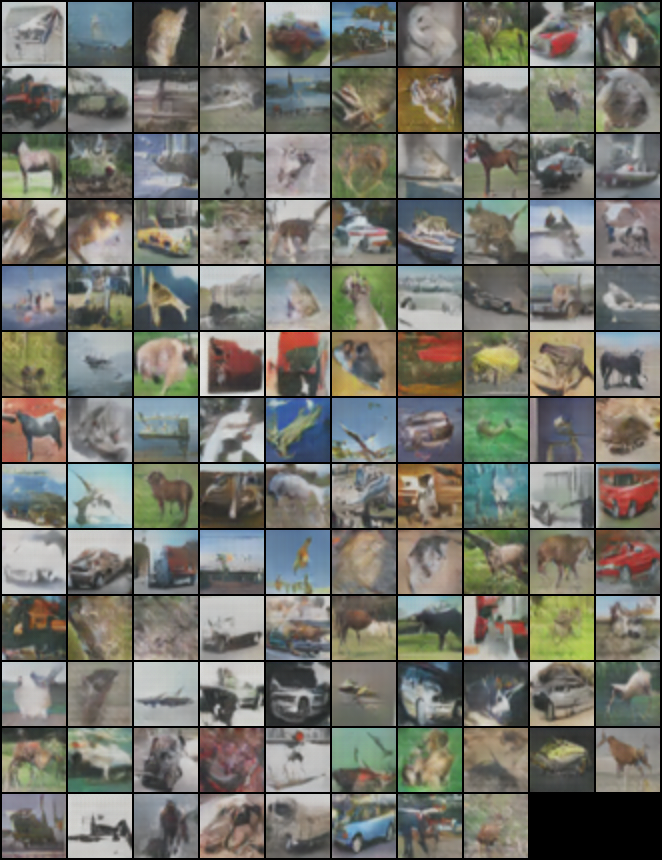

In [47]:
# show your results!
Image.open(os.path.join(sample_dir, "DCG_fake_images-3001.png"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


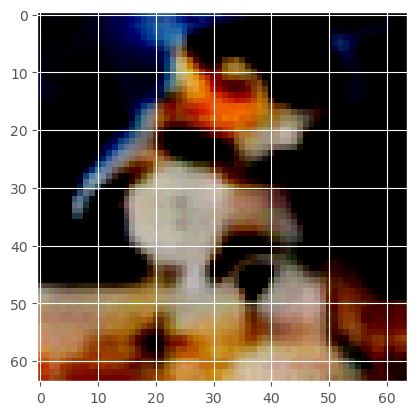

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


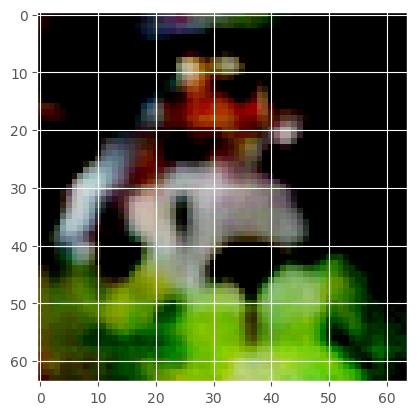

In [104]:
# show the output of model
x = torch.randn(2, CFG.nz, 1, 1)
x_norm = torch.nn.functional.normalize(x)
x_norm = x_norm - 0.5
y = DCG(x_norm.to(CFG.device))
plt.imshow(np.transpose(y.detach().cpu()[0].reshape(3, 64, 64), (1, 2, 0)))
plt.gcf().set_facecolor('white')
plt.show()
plt.imshow(np.transpose(y.detach().cpu()[1].reshape(3, 64, 64), (1, 2, 0)))
plt.show()

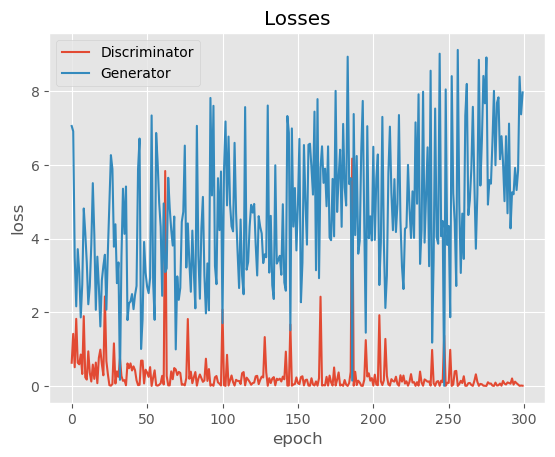

In [50]:
# show the discriminator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

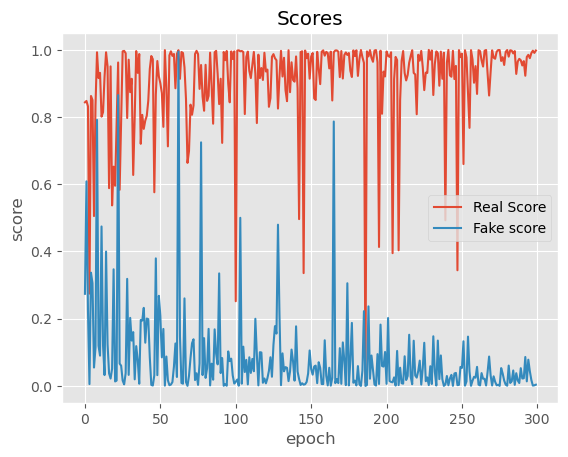

In [51]:
# plot the accuracy of discriminator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");